In [1]:
from resources.CMUTweetTagger import runtagger_parse
import matplotlib.pyplot as plt
import pandas as pd
import enchant
import wordninja
import re

# Define the American English set of allowed words
en_dict = enchant.Dict("en_US")

In [2]:
tweets = []
for period in ['pre', 'post']:
    tweets.append(pd.read_json('data/tweets_{}Greta.json'.format(period)))
    
tweets[1].head(15)

,created_at,id,text,retweet_count,favorite_count,original_retweet_count,original_favorite
0,2019-03-02 09:14:52+00:00,1101772852863340544,Extinction @ExtinctionR are right. Only radic...,0,1,NaN,NaN
1,2019-03-02 09:14:52+00:00,1101772852586409988,“We only have 12 years to fix this” is the mos...,0,0,227.0,1038.0
2,2019-03-02 09:14:50+00:00,1101772843694608384,Our voices are loud &amp; clear. We need #Clim...,0,0,438.0,1413.0
3,2019-03-02 09:14:49+00:00,1101772840980832256,@MeganMcCubbin @HouseofCommons @CarolineLucas ...,0,0,25.0,55.0
4,2019-03-02 09:14:42+00:00,1101772811763412992,We're thanking people working on the climate c...,0,0,55.0,332.0
5,2019-03-02 09:14:42+00:00,1101772809896951808,Day 84 — #ringthebellforclimate \n\nWeek 7 - #...,0,0,124.0,594.0
6,2019-03-02 09:14:36+00:00,1101772786664652800,A-maize-ing. 🌽\n\nThese communities in #Zimbab...,0,0,23.0,67.0
7,2019-03-02 09:14:31+00:00,1101772764007010304,"""The sharp increase in methane emissions corre...",0,0,594.0,452.0
8,2019-03-02 09:14:29+00:00,1101772755362553856,"BAM! More than 10,000 march out in Hamburg thi...",0,0,798.0,1740.0
9,2019-03-02 09:14:15+00:00,1101772694696218624,It's Friday! It's March! Here's the plan:\n\n-...,0,0,404.0,1389.0


`original_retweet_count` and `original_favorite` means that the tweet is not a retweet.

## Tag tweets

In [3]:
# A monte di tutto andrebbero eliminati gli hashtag finali
# prima dello splitting andrebbero rimossi i caratteri speciali e le emoticons


# Splitting hashtag
def split_hashtag(hashtag):
    hash_words = wordninja.split(hashtag)
    
    for word in hash_words:
        if en_dict.check(word) == False:
            return []
    
    return hash_words



# cleaning part
def clean_tweet(row):
    tweet = row.text.split(" ")
    
    for i, word in enumerate(tweet):
        if "#" in word:
            # Initialize the hashtag
            tweet[i] = " "
            # Extract eventually stacked hashtags
            for hashtag in word.split("#")[1:]:
                h_words = split_hashtag(hashtag)
                tweet[i] = tweet[i].join(h_words)
            
    row.text = " ".join(tweet)
    return row

In [4]:
## test 
tweets_pre = tweets[0][:100]

tweets_pre_clean = tweets_pre.apply(clean_tweet, axis=1)

tweets_pre_clean.head()

,created_at,id,text,retweet_count,favorite_count,original_retweet_count,original_favorite
0,2018-06-12 00:09:46+00:00,1006327664976617472,Our new paper in @NatureClimate shows that tem...,0,0,32.0,50.0
1,2018-06-12 00:09:40+00:00,1006327640226189318,“The transition to accessible and clean energy...,0,0,128.0,174.0
2,2018-06-12 00:09:26+00:00,1006327582235688961,"The federal government won't lead on climate, ...",0,0,1349.0,2434.0
3,2018-06-12 00:09:26+00:00,1006327581556084736,Extreme Hurricane Rainfall Expected to Increas...,1,0,NaN,NaN
4,2018-06-12 00:09:14+00:00,1006327528397697025,"""UN Women: Women To Be Heard When Tackling Cli...",2,1,NaN,NaN


In [41]:
ARK_TWEET_NLP_PATH = 'java -XX:ParallelGCThreads=2 -Xmx500m -jar resources/ark-tweet-nlp-0.3.2/ark-tweet-nlp-0.3.2.jar'

tagged_tweets = runtagger_parse(tweets_pre_clean['text'].values, run_tagger_cmd=ARK_TWEET_NLP_PATH)

In [42]:
tagged_tweets[0]

[('Our', 'D', 0.9918),
 ('new', 'A', 0.998),
 ('paper', 'N', 0.9881),
 ('in', 'P', 0.9948),
 ('@NatureClimate', '@', 0.978),
 ('shows', 'V', 0.987),
 ('that', 'D', 0.8964),
 ('temperature', 'N', 0.9922),
 ('goals', 'N', 0.9671),
 ('alone', 'R', 0.7253),
 ('are', 'V', 0.9867),
 ('not', 'R', 0.9995),
 ('sufficient', 'A', 0.9398),
 ('for', 'P', 0.9987),
 ('understanding', 'V', 0.8635),
 ('future', 'A', 0.5608),
 ('extreme', 'A', 0.9519),
 ('weather', 'N', 0.9914),
 ('-', ',', 0.9501),
 ('composition', 'N', 0.9941),
 ('limits', 'N', 0.9563),
 ('also', 'R', 0.9916),
 ('needed', 'V', 0.9335),
 ('@BristolUni', '@', 0.9985),
 ('@ecioxford', '@', 0.9984),
 ('@cabotinstitute', '@', 0.9984),
 ('@ssparrow01', '@', 0.9974),
 ('climate', 'N', 0.9768),
 ('change', 'N', 0.9533),
 ('https://t.co/nUhw7XtRcM', 'U', 0.9927)]

In [43]:
def create_words_df(df, tagged_tweets):
    # Keep only nouns (N), verbs (V), adverbs (R), adjectives (A), pronoun (O) 
    # For now keep also hashtags
    tweets_words = list()
    for i, tags in enumerate(tagged_tweets):
        tweet_id = df.loc[i, 'id']
        for word, tag, conf in tags:
            if tag in ['N', 'V', 'R', 'A', 'O']:
                tweets_words.append({
                    'id':tweet_id,
                    'word': word.lower(),
                    'tag': tag,
                    'conf': conf
                })
                
    return pd.DataFrame(tweets_words)

In [44]:
words_pre = create_words_df(tweets_pre, tagged_tweets)
words_pre.head()

,id,word,tag,conf
0,1006327664976617472,new,A,0.9980
1,1006327664976617472,paper,N,0.9881
2,1006327664976617472,shows,V,0.9870
3,1006327664976617472,temperature,N,0.9922
4,1006327664976617472,goals,N,0.9671


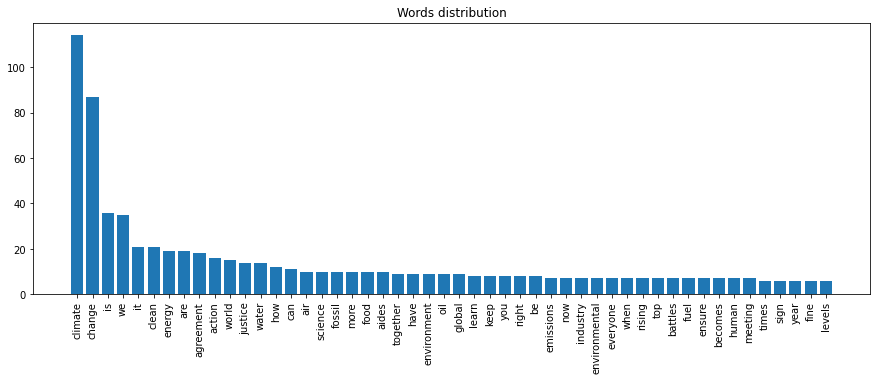

In [45]:
word_counts = words_pre.word.value_counts()
word_counts = word_counts[:50]

# Plot words count
fig, ax = plt.subplots(figsize=(15, 5))
_ = ax.set_title('Words distribution')
_ = ax.bar(x=word_counts.keys().tolist(), height=word_counts.tolist())
_ = ax.tick_params(axis='x', rotation=90)
_ = plt.plot()

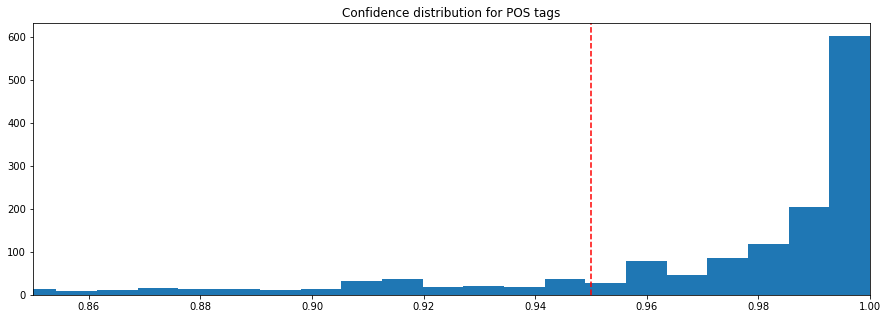

In [46]:
# check confidence
fig, ax = plt.subplots(figsize=(15, 5))
_ = ax.set_title('Confidence distribution for POS tags')
_ = ax.hist(words_pre.conf, bins=100)
_ = ax.set_xlim(left=0.85, right=1.0)
_ = ax.axvline(x=0.95, c='r', ls='--')
_ = plt.show()

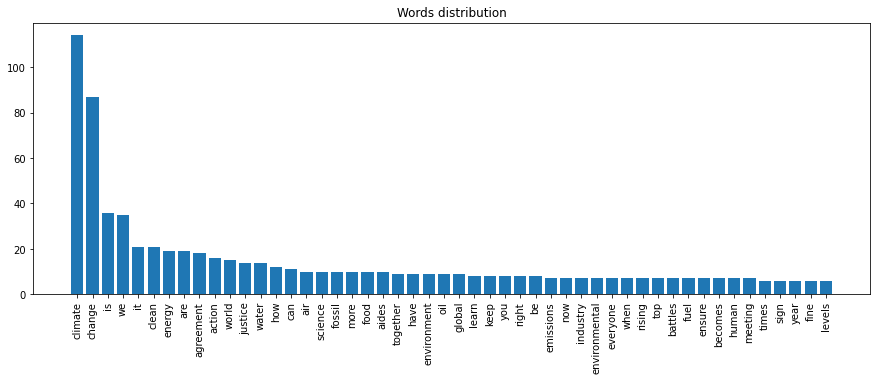

In [47]:
word_counts = words_pre.word.value_counts()
word_counts = word_counts[:50]

# Plot words count
fig, ax = plt.subplots(figsize=(15, 5))
_ = ax.set_title('Words distribution')
_ = ax.bar(x=word_counts.keys().tolist(), height=word_counts.tolist())
_ = ax.tick_params(axis='x', rotation=90)
_ = plt.plot()

In [36]:
words_pre = words_pre[words_pre['conf'] > 0.95]

In [37]:
words_pre.word = words_pre.word.apply(lambda x: re.sub(r'[#]', '', x))